In [2]:
%load_ext autoreload
%autoreload 2
import os
from SRtools import sr_mcmc as srmc
import argparse
from SRtools import config_lib as cl
from SRtools import deathTimesDataSet as dtds
import ast
from SRtools import readResults as rr
from SRtools import readResultsBaysian as rrb
import corner
import matplotlib.pyplot as plt
import matplotlib
from SRtools import SRmodellib as sr
from SRtools import SRmodellib_lifelines as srl
import emcee
import numpy as np
from SRtools import SR_hetro as srh
from SRtools import presets
import matplotlib.pyplot as plt
from SRtools import readResultsBaysian as rrb
from matplotlib import image as mpimg
from matplotlib import offsetbox
from SRtools import utils
from SRtools import plotting_utils as pu

In [3]:
save_fig = True
filetype = 'pdf'

In [4]:
path ='results/summery_mode.csv'

In [5]:
lifespan_param = 'best fit no ext hazard_MedianLifetime'

In [18]:
# columns=[
#     'ecoli',
#     'mice_M', 'mice_F', 'yeast', 'celegance', 
#     'cats_BPH', 
#     'drosophila_853', 'drosophila_707', 'drosophila_441', 'drosophila_217',
#     'humans_M_combined', 'humans_F_combined', 
#     'Staffy_vetCompass', 'Labradors_vetCompass', 'Jack_Russell_vetCompass', 'German_Shepherd_vetCompass'
#     ]

columns = ['mice_F','mice_M','yeast','ecoli','cats_vp_M', 'cats_vp_F',
        'drosophila_853','drosophila_707','drosophila_441','drosophila_217',
        #'Sweden_M_1910_hetro','Sweden_F_1910_hetro','Denmark_M_1900_hetro','Denmark_M_1890_hetro',
        'Staffy_vetCompass','Labradors_vetCompass','Jack_Russell_vetCompass','German_Shepherd_vetCompass',
        #'Denmark_F_1890_hetro','Denmark_F_1900_hetro',
        'celegans','Guiniea_pig_VC','combined_human_F','combined_human_M']

values_by_param, ci_by_param, selected_value_columns = utils.read_summary_csv(path,columns=columns)
columns_plot = ['mice_F','mice_M','yeast','ecoli','cats_vp_M', 'cats_vp_F',
        'drosophila_853','drosophila_707','drosophila_441','drosophila_217',
        'Staffy_vetCompass','Labradors_vetCompass','Jack_Russell_vetCompass','German_Shepherd_vetCompass',
        'celegans','Guiniea_pig_VC','combined_human_F','combined_human_M']
sil = utils.get_summery_csv_df(path,columns=columns_plot)

In [7]:
print(values_by_param.keys())

dict_keys(['xc/eta', 'beta/eta', 'xc^2/epsilon', 'xc', 'eta', 'beta', 'epsilon', 'sqrt(xc/eta)', 's= eta^0.5*xc^1.5/epsilon', 'beta*xc/epsilon', 'eta*xc/epsilon', 'Fx=beta^2/eta*xc', 'Dx =beta*epsilon/eta*xc^2', 'Pk=beta*k/epsilon', 'Fk=beta^2/eta*k', 'Dk =beta*epsilon/eta*k^2', 'Fk^2/Dk=beta^3/eta*epsilon', 'epsilon/beta^2', 'k/beta', 'k^2/epsilon', 'best fit no ext hazard_MedianLifetime', 'best fit no ext hazard_MaxLifetime', 'best fit_MedianLifetime', 'best fit_MaxLifetime', 'data_MedianLifetime', 'data_MaxLifetime', 'ML_lnprob', 'ExtH', 'eta/xc', 'beta/xc', 'epsilon/xc^2', 'k/xc'])


In [23]:
map_drosophila = plt.get_cmap('autumn')
map_dogs = plt.get_cmap('winter')

alpha_1 = 0.4

marker_size = 10
markeredgewidth = 2

sim_plot_props = {
    'combined_human_M': {'color': 'black', 'marker': '^', 'label': 'Human Male', 'alpha': alpha_1, 'markersize': marker_size, 'markeredgewidth': markeredgewidth},
    'combined_human_F': {'color': 'black', 'marker': 'o', 'label': 'Human Female', 'alpha': alpha_1, 'markersize': marker_size, 'markeredgewidth': markeredgewidth},
    'ecoli': {'color': 'purple', 'marker': 's', 'label': 'E. coli', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
    'Jack_Russell_vetCompass': {'color': map_dogs(0 % map_dogs.N), 'marker': 'D', 'label': 'Jack Russell', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
    'Labradors_vetCompass': {'color': map_dogs(100 % map_dogs.N), 'marker': 'D', 'label': 'Labrador', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
    'Staffy_vetCompass': {'color': map_dogs(140 % map_dogs.N), 'marker': 'D', 'label': 'Staffy', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
    'German_Shepherd_vetCompass': {'color': map_dogs(180 % map_dogs.N), 'marker': 'D', 'label': 'German Shepherd', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
    'cats_vp_M': {'color': 'green', 'marker': '^', 'label': 'Cats Male', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
    'cats_vp_F': {'color': 'green', 'marker': 'o', 'label': 'Cats Female', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
    'mice_F': {'color': 'gray', 'marker': 'o', 'label': 'Mice Female', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
    'mice_M': {'color': 'gray', 'marker': '^', 'label': 'Mice Male', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
    'celegans': {'color': 'lime', 'marker': 's', 'label': 'C. elegans', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
    'drosophila_853': {'color': map_drosophila(170 % map_drosophila.N), 'marker': 'd', 'label': 'Drosophila genotype 853', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
    'drosophila_441': {'color': map_drosophila(115 % map_drosophila.N), 'marker': 'd', 'label': 'Drosophila genotype 441', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
    'drosophila_707': {'color': map_drosophila(75 % map_drosophila.N), 'marker': 'd', 'label': 'Drosophila genotype 707', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
    'drosophila_217': {'color': map_drosophila(30 % map_drosophila.N), 'marker': 'd', 'label': 'Drosophila genotype 217', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
    'yeast': {'color': 'brown', 'marker': 's', 'label': 'Yeast', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
    'Guiniea_pig_VC': {'color': 'pink', 'marker': 'D', 'label': 'Guinea Pig', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
}



map_dogs.N

256

# 2D

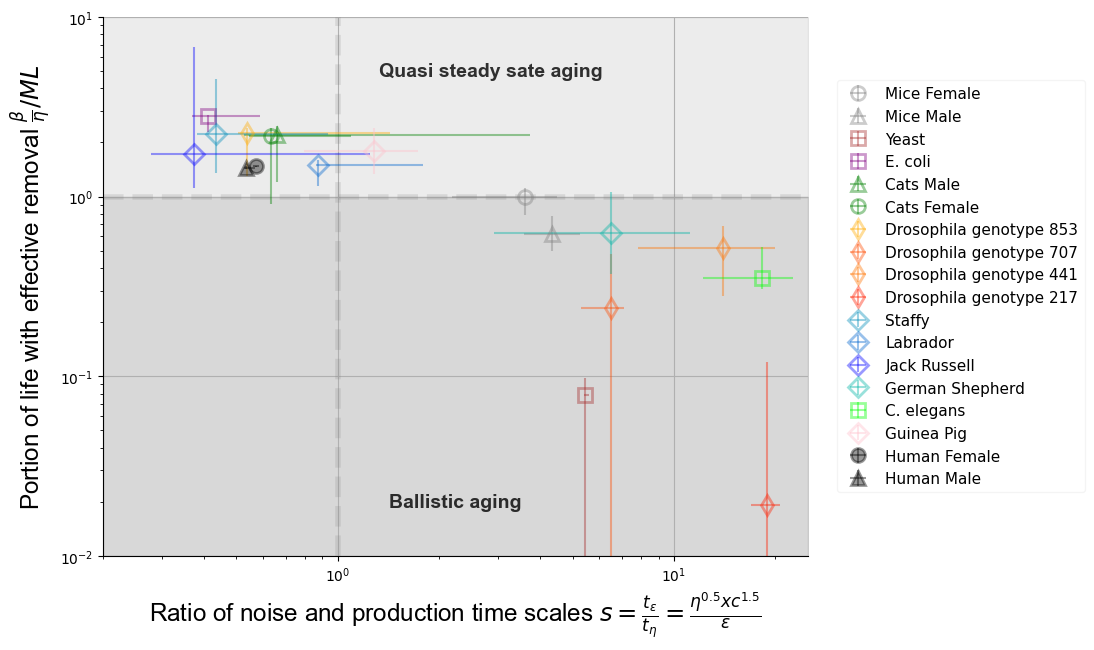

In [49]:
from matplotlib.patheffects import withStroke

sf = 0.7

fig_size = (13 * sf, 10 * sf)
fig, ax = plt.subplots(figsize=fig_size)
# fig.subplots_adjust(wspace=0.4)

# if i in [8,7,6]:
#     dparam = idict[20]
# elif i in [11,2,3]:
#     mparam = idict[20]
# elif i in[1]:
#     mparam = [idict[20],idict[20]]

title_font = {'fontname': 'Arial', 'size': f'{22 * sf}', 'color': 'black', 'weight': 'normal'}
axis_font = {'fontname': 'Arial', 'size': f'{25 * sf}', 'weight': 'normal'}
text_font = {'fontname': 'Arial', 'size': f'{20 * sf}', 'weight': 'bold', 'horizontalalignment': 'center', 'alpha': 0.8}

npad = 10

ax.axhline(1, color='gray', linestyle='--', alpha=0.2, linewidth=4)
ax.axvline(1, color='gray', linestyle='--', alpha=0.2, linewidth=4)
i = 6
dparam = lifespan_param
mparam = None
# xlim =[3.5e3,5.5e3]
# ylim = [1e-6, 3e-4]
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
# color the part of the plot below y=1 in light grey
_, x, y, _, _, _, fig, plot_props0 = pu.plotParams2D(
    sil,
    ax=ax,
    param2='beta/eta',
    multiply_param2=mparam,
    divide_by_param2=dparam,
    param1='s= eta^0.5*xc^1.5/epsilon',
    divide_by_param1=None,
    yscale='log',
    xscale='log',
    full_output=True,
    plot_props=sim_plot_props,
    legend=True,
    best_fit=False
)
# rr.plotParams2D(sil,ax=ax,param2=idict[i],multiply_param2=mparam,divide_by_param2=dparam,param1=idict[20],divide_by_param1=None,yscale='log',xscale='log',full_output=False,legend = False)
ax.set_ylabel(r'Portion of life with effective removal $\frac{\beta}{\eta}/ML$', **axis_font)
ax.set_xlabel(r'Ratio of noise and production time scales $s=\frac{t_\epsilon}{t_\eta}=\frac{\eta^{0.5} xc^{1.5}}{\epsilon}$', **axis_font)

xlim = [0.2, 25]
ylim = [0.01, 10]

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.fill_between(xlim, ylim[0], 1, color='grey', alpha=0.3, zorder=1)
ax.fill_between(xlim, 1, ylim[1], color='grey', alpha=0.15, zorder=1)

# Put legend outside plot to the right with background
legend = ax.legend(loc='center left', bbox_to_anchor=(1.03, 0.5), fontsize=11, frameon=True)
# legend.get_frame().set_facecolor('gray')
legend.get_frame().set_alpha(0.2)

# remove title
ax.title.set_visible(False)

# Add the text again without the box
ax.text(
    0.5, 0.09,
    "Ballistic aging",
    transform=ax.transAxes,
    fontdict=text_font
)
ax.text(
    0.55, 0.89,
    "Quasi steady sate aging",
    transform=ax.transAxes,
    fontdict=text_font
)

if save_fig:
    fig.savefig(f'plots/Fig_similitude_BetaEta_vs_s.{filetype}', bbox_inches='tight', format=filetype, transparent=True)


# 3D

Regression R2 (fit): 0.9370
Fixed-coefficient regression line: log10(e/xc^2 L) ≈ 0.50 log10(η/xc L²) + 0.50 log10(β/xc L) + -0.95
R2 with a=b=0.5: 0.9111


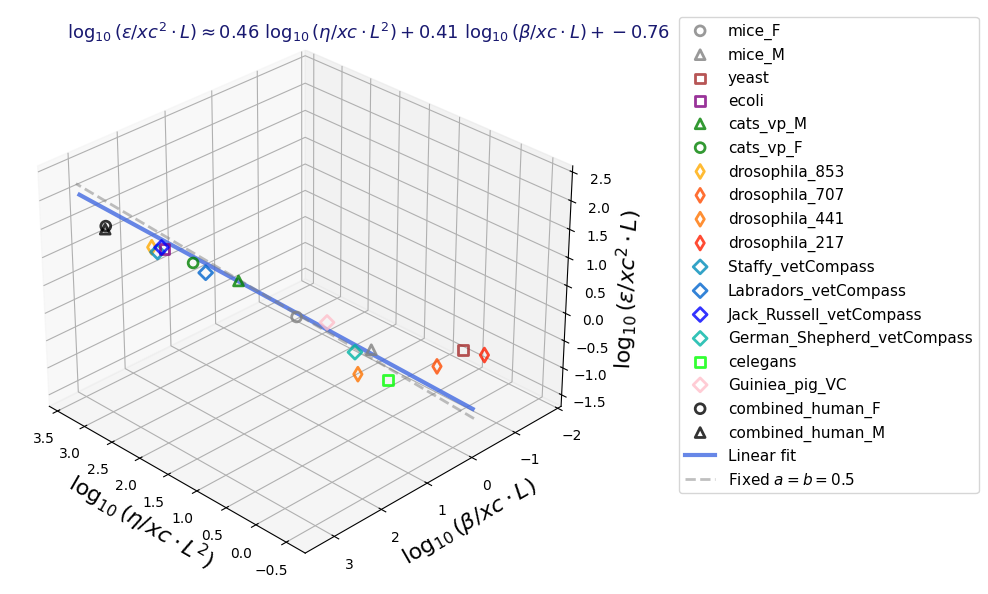

In [78]:
path3d = 'results/summery_mode.csv'
values_by_param3d, ci_by_param3d, selected_value_columns3d = utils.read_summary_csv(path3d,columns=columns)
L = np.array(values_by_param3d[lifespan_param])
x_param = np.array(values_by_param3d['eta/xc']) * (L**2)
y_param = np.array(values_by_param3d['beta/xc']) * L
z_param = np.array(values_by_param3d['epsilon/xc^2']) * L

from mpl_toolkits.mplot3d import Axes3D

sf3d = 0.7
fig3d = plt.figure(figsize=(13*sf3d, 10*sf3d))
ax3d = fig3d.add_subplot(111, projection='3d')

# Set axis to log scale by taking log10 of data
x_plot = np.log10(x_param)
y_plot = np.log10(y_param)
z_plot = np.log10(z_param)

marker_size = 10
markeredgewidth = 2
alpha_1 = 0.85
for idx in range(len(x_param)):
    org_name = columns[idx]
    plot_kwargs = {}
    if org_name and org_name in sim_plot_props:
        plot_kwargs = sim_plot_props[org_name]
    color = plot_kwargs.get('color', 'black')
    marker = plot_kwargs.get('marker', 'o')
    alpha = plot_kwargs.get('alpha', alpha_1)
    markersize = 50
    markerfacecolor = plot_kwargs.get('markerfacecolor', 'none')
    markeredgewidth = plot_kwargs.get('markeredgewidth', markeredgewidth)
    ax3d.scatter(
        x_plot[idx], y_plot[idx], z_plot[idx],
        color=color, marker=marker, s=markersize,
        edgecolor=color, linewidths=markeredgewidth,
        facecolors=markerfacecolor, alpha=0.8,
        label=org_name if org_name else None
    )
    ax3d.view_init(elev=30, azim=135)

from sklearn.linear_model import LinearRegression

X_reg = np.column_stack((x_plot, y_plot))
z_reg = z_plot

reg3d = LinearRegression().fit(X_reg, z_reg)
a, b = reg3d.coef_
c = reg3d.intercept_

# Calculate R2 for the fit
r2_real = reg3d.score(X_reg, z_reg)
print(f"Regression R2 (fit): {r2_real:.4f}")

# Print line and R2 if using a = 0.5, b = 0.5 (intercept fit)
a_fixed = 0.5
b_fixed = 0.5
# Fit only intercept
z_pred_fixed = a_fixed * x_plot + b_fixed * y_plot
from sklearn.metrics import r2_score
c_fixed = np.mean(z_reg - z_pred_fixed)
z_pred_fixed_c = a_fixed * x_plot + b_fixed * y_plot + c_fixed
r2_fixed = r2_score(z_reg, z_pred_fixed_c)
print(f"Fixed-coefficient regression line: log10(e/xc^2 L) ≈ {a_fixed:.2f} log10(η/xc L²) + {b_fixed:.2f} log10(β/xc L) + {c_fixed:.2f}")
print(f"R2 with a=b=0.5: {r2_fixed:.4f}")

trend_eq = (
    r"$\log_{10}(\epsilon/xc^2 \cdot L) \approx "
    + "{:.2f}".format(a) + r"\ \log_{10}(\eta/xc \cdot L^2) + "
    + "{:.2f}".format(b) + r"\ \log_{10}(\beta/xc \cdot L) + "
    + "{:.2f}".format(c) + r"$"
)

# For a regression line in 3D, follow the line given by the regression equation along the main axis of variation.
direction = np.array([a, b])
direction = direction / np.linalg.norm(direction)
proj = X_reg @ direction
t_min, t_max = proj.min(), proj.max()
t_line = np.linspace(t_min, t_max, 100)
x_line = x_plot.mean() + direction[0] * (t_line - t_line.mean())
y_line = y_plot.mean() + direction[1] * (t_line - t_line.mean())
z_line = a * x_line + b * y_line + c

# Plot best-fit regression line
ax3d.plot(x_line, y_line, z_line, color='royalblue', linewidth=3, alpha=0.8, label="Linear fit")

# Also plot the fixed-coefficient regression line (a=0.5, b=0.5)
# For same direction, use normalized [0.5, 0.5]
direction_fixed = np.array([a_fixed, b_fixed])
direction_fixed = direction_fixed / np.linalg.norm(direction_fixed)
proj_fixed = X_reg @ direction_fixed
t_line_fixed = np.linspace(proj_fixed.min(), proj_fixed.max(), 100)
x_line_fixed = x_plot.mean() + direction_fixed[0] * (t_line_fixed - t_line_fixed.mean())
y_line_fixed = y_plot.mean() + direction_fixed[1] * (t_line_fixed - t_line_fixed.mean())
z_line_fixed = a_fixed * x_line_fixed + b_fixed * y_line_fixed + c_fixed
ax3d.plot(x_line_fixed, y_line_fixed, z_line_fixed, color='gray', linewidth=2, alpha=0.5, linestyle='dashed', label=r"Fixed $a=b=0.5$")

# Annotate with the regression equation
ax3d.text2D(
    0.1, 0.95,
    trend_eq,
    transform=ax3d.transAxes,
    fontsize=13,
    color='midnightblue',
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='w')
)

ax3d.set_xlabel(r'$\log_{10}(\eta/xc \cdot L^2)$', fontsize=16)
ax3d.set_ylabel(r'$\log_{10}(\beta/xc \cdot L)$', fontsize=16)
ax3d.set_zlabel(r'$\log_{10}(\epsilon/xc^2 \cdot L)$', fontsize=16)

handles, labels_ = ax3d.get_legend_handles_labels()
by_label = dict(zip(labels_, handles))
if by_label:
    ax3d.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.15,1), loc='upper left', fontsize=11)

fig3d = plt.gcf()
plt.tight_layout()
plt.show()


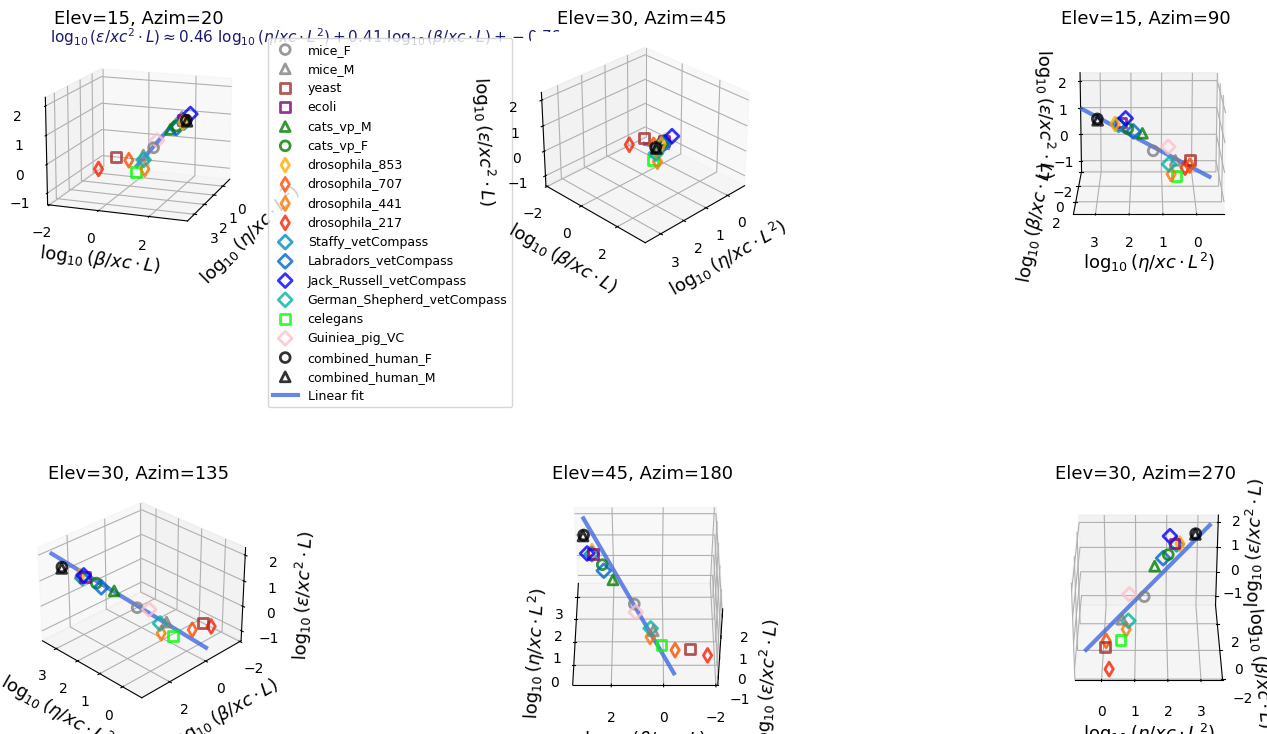

In [45]:
path3d = 'results/summery_mode.csv'
values_by_param3d, ci_by_param3d, selected_value_columns3d = utils.read_summary_csv(path3d, columns=columns)
L = np.array(values_by_param3d[lifespan_param])
x_param = np.array(values_by_param3d['eta/xc']) * (L ** 2)
y_param = np.array(values_by_param3d['beta/xc']) * L
z_param = np.array(values_by_param3d['epsilon/xc^2']) * L

from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression

sf3d = 0.7

# Convert data to log-scale
x_plot = np.log10(x_param)
y_plot = np.log10(y_param)
z_plot = np.log10(z_param)

# Fit a 3D linear regression
X_reg = np.column_stack((x_plot, y_plot))
z_reg = z_plot
reg3d = LinearRegression().fit(X_reg, z_reg)
a, b = reg3d.coef_
c = reg3d.intercept_

trend_eq = (
    r"$\log_{10}(\epsilon/xc^2 \cdot L) \approx "
    + "{:.2f}".format(a) + r"\ \log_{10}(\eta/xc \cdot L^2) + "
    + "{:.2f}".format(b) + r"\ \log_{10}(\beta/xc \cdot L) + "
    + "{:.2f}".format(c) + r"$"
)

# Compute regression line
direction = np.array([a, b])
direction = direction / np.linalg.norm(direction)
proj = X_reg @ direction
t_min, t_max = proj.min(), proj.max()
t_line = np.linspace(t_min, t_max, 100)
x_line = x_plot.mean() + direction[0] * (t_line - t_line.mean())
y_line = y_plot.mean() + direction[1] * (t_line - t_line.mean())
z_line = a * x_line + b * y_line + c

# Prepare 6 different 3D viewing angles
angles = [
    (15, 20),   # original
    (30, 45),
    (15, 90),
    (30, 135),
    (45, 180),
    (30, 270)
]

fig3d, axes3d = plt.subplots(2, 3, subplot_kw={'projection': '3d'}, figsize=(18*sf3d, 12*sf3d))
axes3d = axes3d.flatten()

for i, (elev, azim) in enumerate(angles):
    ax3d = axes3d[i]
    # Scatter points for each organism using sim_plot_props
    for idx in range(len(x_param)):
        org_name = columns[idx]
        plot_kwargs = {}
        if org_name and org_name in sim_plot_props:
            plot_kwargs = sim_plot_props[org_name]
        color = plot_kwargs.get('color', 'black')
        marker = plot_kwargs.get('marker', 'o')
        alpha = plot_kwargs.get('alpha', 0.85)
        markersize = 50
        markerfacecolor = plot_kwargs.get('markerfacecolor', 'none')
        markeredgewidth = plot_kwargs.get('markeredgewidth', 2)
        ax3d.scatter(
            x_plot[idx], y_plot[idx], z_plot[idx],
            color=color, marker=marker, s=markersize,
            edgecolor=color, linewidths=markeredgewidth,
            facecolors=markerfacecolor, alpha=0.8,
            label=org_name if org_name else None
        )

    # Plot regression line
    ax3d.plot(x_line, y_line, z_line, color='royalblue', linewidth=3, alpha=0.8, label="Linear fit")

    # Axis labels and view
    ax3d.set_xlabel(r'$\log_{10}(\eta/xc \cdot L^2)$', fontsize=13)
    ax3d.set_ylabel(r'$\log_{10}(\beta/xc \cdot L)$', fontsize=13)
    ax3d.set_zlabel(r'$\log_{10}(\epsilon/xc^2 \cdot L)$', fontsize=13)
    ax3d.view_init(elev=elev, azim=azim)
    ax3d.set_title(f'Elev={elev}, Azim={azim}', fontsize=13)
    if i == 0:
        # Only show equation on the first subplot
        ax3d.text2D(
            0.1, 0.95,
            trend_eq,
            transform=ax3d.transAxes,
            fontsize=11,
            color='midnightblue',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='w')
        )

    # Only deduplicate legend for first subplot to avoid overlaps
    if i == 0:
        handles, labels_ = ax3d.get_legend_handles_labels()
        by_label = dict(zip(labels_, handles))
        if by_label:
            ax3d.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    else:
        ax3d.legend([],[], frameon=False)

plt.tight_layout()
plt.show()


/var/folders/pr/hngn4yrn3v3gt3069stbsfqh0000gp/T/ipykernel_66974/2661690443.py:172: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on the right for legend


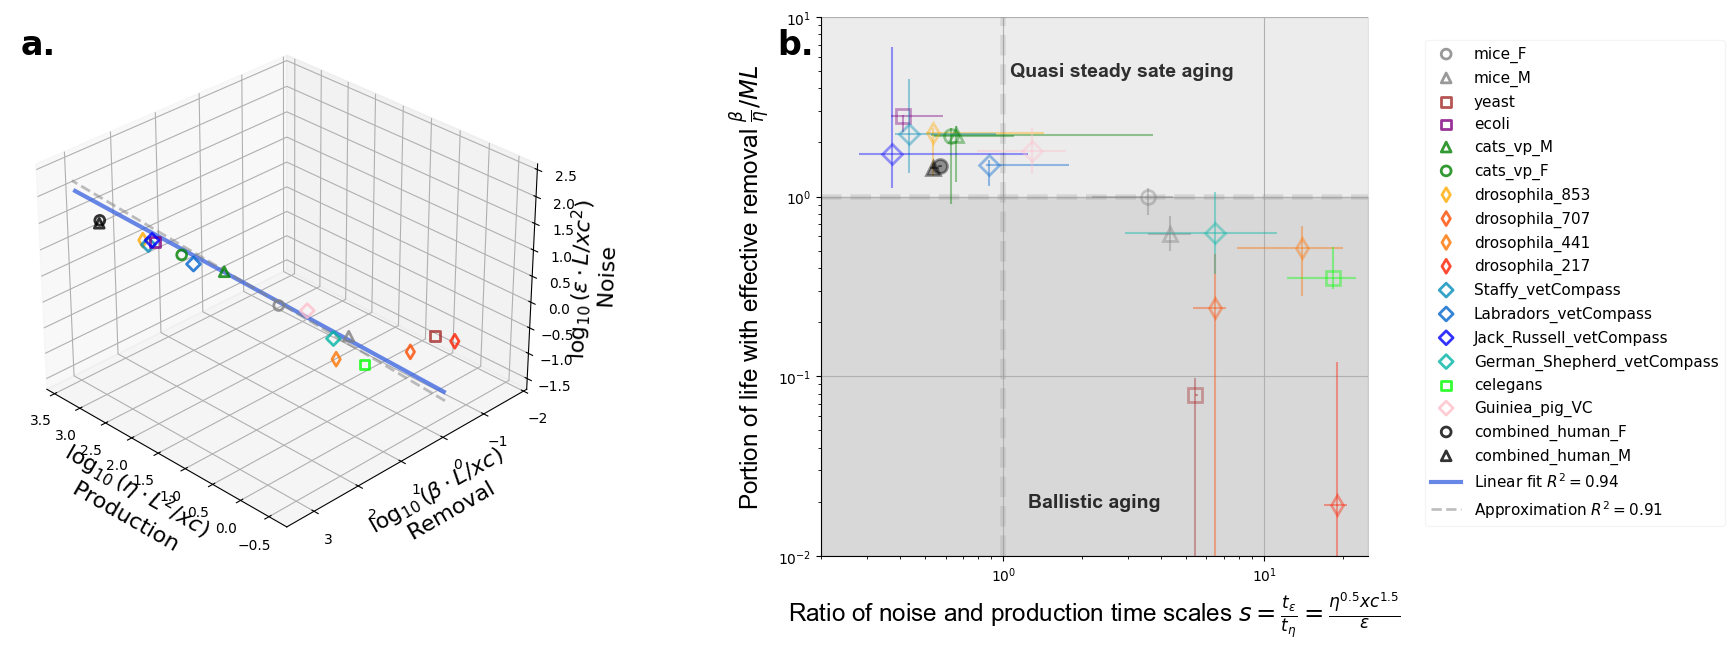

In [82]:
# Combined 2-panel figure: 3D (left, a.) and 2D (right, b.)
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from matplotlib.patheffects import withStroke
import matplotlib.gridspec as gridspec

sf = 0.7
sf3d = 0.7

# Create figure with custom gridspec to make right panel (2D) a bit wider (increase final width ratio)
fig = plt.figure(figsize=(26*sf, 10*sf))
# Make the right (2D) panel a bit wider: previously [1.0, 0.05, 0.65], now [1.0, 0.05, 0.85]
gs = gridspec.GridSpec(1, 3, width_ratios=[1.0, 0.05, 0.85], wspace=0.23)

ax3d = fig.add_subplot(gs[0, 0], projection='3d')  # Left panel for 3D
ax2d = fig.add_subplot(gs[0, 2])  # Right panel for 2D (use third column)

# ========== LEFT PANEL: 3D Plot ==========
path3d = 'results/summery_mode.csv'
values_by_param3d, ci_by_param3d, selected_value_columns3d = utils.read_summary_csv(path3d, columns=columns)
L = np.array(values_by_param3d[lifespan_param])
x_param = np.array(values_by_param3d['eta/xc']) * (L ** 2)
y_param = np.array(values_by_param3d['beta/xc']) * L
z_param = np.array(values_by_param3d['epsilon/xc^2']) * L

# Set axis to log scale by taking log10 of data
x_plot = np.log10(x_param)
y_plot = np.log10(y_param)
z_plot = np.log10(z_param)

marker_size = 10
markeredgewidth = 2
alpha_1 = 0.85

# Scatter points for each organism using sim_plot_props
for idx in range(len(x_param)):
    org_name = columns[idx]
    plot_kwargs = {}
    if org_name and org_name in sim_plot_props:
        plot_kwargs = sim_plot_props[org_name]
    color = plot_kwargs.get('color', 'black')
    marker = plot_kwargs.get('marker', 'o')
    alpha = plot_kwargs.get('alpha', alpha_1)
    markersize = 50
    markerfacecolor = plot_kwargs.get('markerfacecolor', 'none')
    markeredgewidth = plot_kwargs.get('markeredgewidth', markeredgewidth)
    ax3d.scatter(
        x_plot[idx], y_plot[idx], z_plot[idx],
        color=color, marker=marker, s=markersize,
        edgecolor=color, linewidths=markeredgewidth,
        facecolors=markerfacecolor, alpha=0.8,
        label=org_name if org_name else None
    )
ax3d.view_init(elev=30, azim=135)

# Fit a 3D linear trend
X_reg = np.column_stack((x_plot, y_plot))
z_reg = z_plot
reg3d = LinearRegression().fit(X_reg, z_reg)
a, b = reg3d.coef_
c = reg3d.intercept_

# Compute regression line
direction = np.array([a, b])
direction = direction / np.linalg.norm(direction)
proj = X_reg @ direction
t_min, t_max = proj.min(), proj.max()
t_line = np.linspace(t_min, t_max, 100)
x_line = x_plot.mean() + direction[0] * (t_line - t_line.mean())
y_line = y_plot.mean() + direction[1] * (t_line - t_line.mean())
z_line = a * x_line + b * y_line + c

# Plot the regression line
ax3d.plot(x_line, y_line, z_line, color='royalblue', linewidth=3, alpha=0.8, label=r"Linear fit $R^2=0.94$")

# -------- Begin: Add also the fixed-coefficient regression line --------
# Also plot the fixed-coefficient regression line (a=0.5, b=0.5)
a_fixed = 0.5
b_fixed = 0.5
# Calculate the proper intercept for fixed coefficients
z_pred_fixed = a_fixed * x_plot + b_fixed * y_plot
c_fixed = np.mean(z_reg - z_pred_fixed)
direction_fixed = np.array([a_fixed, b_fixed])
direction_fixed = direction_fixed / np.linalg.norm(direction_fixed)
proj_fixed = X_reg @ direction_fixed
t_line_fixed = np.linspace(proj_fixed.min(), proj_fixed.max(), 100)
x_line_fixed = x_plot.mean() + direction_fixed[0] * (t_line_fixed - t_line_fixed.mean())
y_line_fixed = y_plot.mean() + direction_fixed[1] * (t_line_fixed - t_line_fixed.mean())
z_line_fixed = a_fixed * x_line_fixed + b_fixed * y_line_fixed + c_fixed
ax3d.plot(x_line_fixed, y_line_fixed, z_line_fixed, color='gray', linewidth=2, alpha=0.5, linestyle='dashed', label=r"Approximation $R^2=0.91$")
# -------- End: fixed-coefficient regression line --------



ax3d.set_xlabel(r'$\log_{10}(\eta\cdot L^2/xc )$'+'\n Production', fontsize=16)
ax3d.set_ylabel(r'$\log_{10}(\beta\cdot L/xc )$'+'\n Removal', fontsize=16)
ax3d.set_zlabel(r'$\log_{10}(\epsilon\cdot L/xc^2 )$'+'\n Noise', fontsize=16)

# Get handles and labels from 3D plot for legend (but don't display on 3D plot)
handles_3d, labels_3d = ax3d.get_legend_handles_labels()
by_label_3d = dict(zip(labels_3d, handles_3d))

# Add label "a." to left panel
ax3d.text2D(0.02, 0.98, 'a.', transform=ax3d.transAxes, 
            fontsize=24, weight='bold', va='top', ha='left')

# ========== RIGHT PANEL: 2D Plot ==========
title_font = {'fontname': 'Arial', 'size': f'{22 * sf}', 'color': 'black', 'weight': 'normal'}
axis_font = {'fontname': 'Arial', 'size': f'{25 * sf}', 'weight': 'normal'}
text_font = {'fontname': 'Arial', 'size': f'{20 * sf}', 'weight': 'bold', 'horizontalalignment': 'center', 'alpha': 0.8}

ax2d.axhline(1, color='gray', linestyle='--', alpha=0.2, linewidth=4)
ax2d.axvline(1, color='gray', linestyle='--', alpha=0.2, linewidth=4)

dparam = lifespan_param
mparam = None

_, x, y, _, _, _, _, plot_props0 = pu.plotParams2D(
    sil,
    ax=ax2d,
    param2='beta/eta',
    multiply_param2=mparam,
    divide_by_param2=dparam,
    param1='s= eta^0.5*xc^1.5/epsilon',
    divide_by_param1=None,
    yscale='log',
    xscale='log',
    full_output=True,
    plot_props=sim_plot_props,
    legend=False,  # Don't show legend on 2D plot
    best_fit=False
)

ax2d.set_ylabel(r'Portion of life with effective removal $\frac{\beta}{\eta}/ML$', **axis_font)
ax2d.set_xlabel(r'Ratio of noise and production time scales $s=\frac{t_\epsilon}{t_\eta}=\frac{\eta^{0.5} xc^{1.5}}{\epsilon}$', **axis_font)

xlim = [0.2, 25]
ylim = [0.01, 10]

ax2d.set_xlim(xlim)
ax2d.set_ylim(ylim)
ax2d.fill_between(xlim, ylim[0], 1, color='grey', alpha=0.3, zorder=1)
ax2d.fill_between(xlim, 1, ylim[1], color='grey', alpha=0.15, zorder=1)

# remove title
ax2d.title.set_visible(False)

# Add the text again without the box
ax2d.text(
    0.5, 0.09,
    "Ballistic aging",
    transform=ax2d.transAxes,
    fontdict=text_font
)
ax2d.text(
    0.55, 0.89,
    "Quasi steady sate aging",
    transform=ax2d.transAxes,
    fontdict=text_font
)

# Add label "b." to right panel - positioned to the left of the plot
ax2d.text(-0.08, 0.98, 'b.', transform=ax2d.transAxes, 
          fontsize=24, weight='bold', va='top', ha='left')

# Add legend from 3D plot to the right of the right panel
if by_label_3d:
    fig.legend(by_label_3d.values(), by_label_3d.keys(), 
               loc='center right', bbox_to_anchor=(1.1, 0.5), 
               fontsize=11, frameon=True, framealpha=0.2)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on the right for legend

if save_fig:
    fig.savefig(f'plots/Fig_combined_3D_2D.{filetype}', bbox_inches='tight', format=filetype, transparent=True)

plt.show()


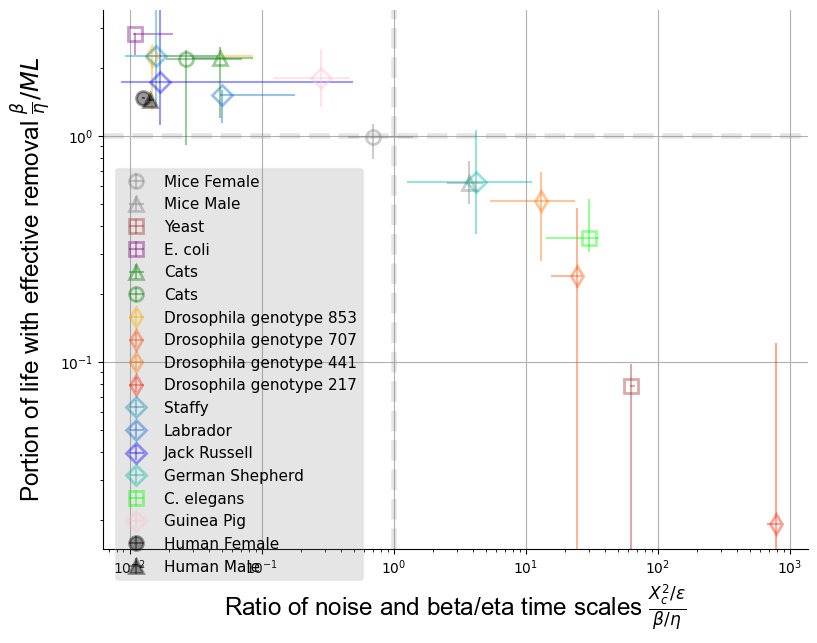

In [18]:
from matplotlib.patheffects import withStroke

sf =0.7

fig_size = (13*sf,10*sf) 
fig, ax = plt.subplots(figsize=fig_size)
# fig.subplots_adjust(wspace=0.4) 




# if i in [8,7,6]:
#     dparam = idict[20]
# elif i in [11,2,3]:
#     mparam = idict[20]
# elif i in[1]:
#     mparam = [idict[20],idict[20]]

title_font = {'fontname':'Arial', 'size':f'{22*sf}', 'color':'black', 'weight':'normal'}
axis_font = {'fontname':'Arial', 'size':f'{25*sf}','weight':'normal'}   
text_font = {'fontname':'Arial', 'size':f'{20*sf}','weight':'bold','horizontalalignment':'center'}

npad =10

ax.axhline(1, color='gray', linestyle='--', alpha=0.2, linewidth=4)
ax.axvline(1, color='gray', linestyle='--', alpha=0.2, linewidth=4)
i=6
dparam = lifespan_param
mparam = None
# xlim =[3.5e3,5.5e3]
# ylim = [1e-6, 3e-4]
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
#color the part of the plot below y=1 in light grey
_, x,y,_,_,_, fig,plot_props0 =pu.plotParams2D(sil,ax=ax,param2='beta/eta',multiply_param2=mparam,divide_by_param2=dparam,param1='xc^2/epsilon',divide_by_param1='beta/eta',yscale='log',xscale='log',
                                               full_output=True,plot_props=sim_plot_props,legend = True,best_fit=False)
# rr.plotParams2D(sil,ax=ax,param2=idict[i],multiply_param2=mparam,divide_by_param2=dparam,param1=idict[20],divide_by_param1=None,yscale='log',xscale='log',full_output=False,legend = False)
ax.set_ylabel(r'Portion of life with effective removal $\frac{\beta}{\eta}/ML$', **axis_font)
ax.set_xlabel(r'Ratio of noise and beta/eta time scales $\frac{X_c^2/\epsilon}{\beta/\eta}$', **axis_font)




#put legend inside plot bottom left corner
# Add fill color and alpha
legend = ax.legend(loc='upper right', bbox_to_anchor=(0.38, 0.72), fontsize=11, frameon=True)
legend.get_frame().set_facecolor('gray')
legend.get_frame().set_alpha(0.2)

#remove title
ax.title.set_visible(False)

if False:
    fig.savefig(f'plots/Fig_similitude_BetaEta_vs_s.{filetype}',bbox_inches='tight',format=filetype,transparent=True)
